In [1]:
import pandas as pd
import numpy as np

In [2]:
df_mayo = pd.read_csv('/scratch/mcesped/Datasets/segments_mayo.csv', sep=",", index_col="index")
df_fnusa = pd.read_csv('/scratch/mcesped/Datasets/segments_fnusa.csv', sep=",", index_col="index")

# Noise detection

## Fnusa

I'll use fnusa for training as it has more data after curation

In [3]:
counter = {
    # 'pw':[],
    # 'noise':[],
    # 'path':[],
    # 'phys':[]
}
df_evaluated = df_fnusa
# Remove power line
df_evaluated = df_evaluated.loc[df_evaluated.category_id != 0]
df_evaluated.loc[:,'category_id'] = df_evaluated.category_id - 1

counter = {
    # 'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

subjects from inst fnusa
{'noise': [0, 2892, 12, 8463, 5059, 0, 5416, 18, 0, 5876, 3339, 1343, 181], 'path': [1912, 1657, 8076, 0, 1527, 1554, 7738, 1896, 6750, 4260, 4072, 7710, 5318], 'phys': [0, 7809, 0, 0, 5452, 962, 2689, 20860, 0, 1545, 2890, 38217, 14136]}


In [4]:
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

noise 
Number of subj: 10 
Median events per subj 3115.5 
Total events proportion 18.147960518624497 
Total events: 32599

path 
Number of subj: 12 
Median events per subj 4166.0 
Total events proportion 29.21020547907075 
Total events: 52470

phys 
Number of subj: 9 
Median events per subj 5452.0 
Total events proportion 52.64183400230475 
Total events: 94560



In [5]:
# Curate
max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1300
}
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa


In [6]:
len(df_curated)

40408

In [7]:
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))

for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
noise 
Number of subj: 10 
Median events per subj 2946.0 
Total events proportion 48.124133834884184 
Total events: 19446

path 
Number of subj: 12 
Median events per subj 800.0 
Total events proportion 23.75767174816868 
Total events: 9600

phys 
Number of subj: 9 
Median events per subj 1300.0 
Total events proportion 28.11819441694714 
Total events: 11362



Therefore, for a 70/30 split, we would need in the val set per class:

In [8]:
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat, f'\nTotal events in val set: {np.sum(array_count)*0.3}\n')

noise 
Total events in val set: 5833.8

path 
Total events in val set: 2880.0

phys 
Total events in val set: 3408.6



In [9]:
# This would mean a dist of:
total = 5833.8+2880.0+3408.6
5833.8/total, 2880.0/total, 3408.6/total
# This is great!

(0.48124133834884186, 0.2375767174816868, 0.2811819441694714)

In [10]:
for tuple_events in zip(counter['noise'],counter['path'],counter['phys']):
    print(tuple_events)

(0, 800, 0)
(2892, 800, 1300)
(12, 800, 0)
(3000, 0, 0)
(3000, 800, 1300)
(0, 800, 962)
(3000, 800, 1300)
(18, 800, 1300)
(0, 800, 0)
(3000, 800, 1300)
(3000, 800, 1300)
(1343, 800, 1300)
(181, 800, 1300)


In [11]:
df_curated.patient_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

Based on this distribution:
**Val subjects:** 2, 7, 6, 9

- Noise: 2892, 3000, 0
- Path: 800, 800,800
- Phys: 1300, 1300, 962

In [13]:
5834-2892-3000, 2880.0-800-800-800-800, 3409-1300-1300-962

(-58, -320.0, -153)

## Mayo

In [56]:
counter = {
    # 'pw':[],
    # 'noise':[],
    # 'path':[],
    # 'phys':[]
}
df_evaluated = df_mayo
# Remove power line
df_evaluated = df_evaluated.loc[df_evaluated.category_id != 0]
df_evaluated.loc[:,'category_id'] = df_evaluated.category_id - 1

counter = {
    # 'pw':[],
    'noise':[],
    'path':[],
    'phys':[]
}
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

subjects from inst mayo
{'noise': [2318, 0, 466, 4636, 2063, 1002, 12873, 0, 0, 740, 0, 3699, 4096, 1700, 5613, 1278, 58, 761], 'path': [0, 883, 1923, 0, 0, 0, 0, 0, 2816, 0, 3426, 0, 0, 0, 0, 0, 3432, 2747], 'phys': [330, 8653, 399, 2057, 790, 6583, 0, 25951, 0, 0, 498, 177, 6098, 3126, 0, 1424, 0, 644]}


In [42]:
for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

noise 
Number of subj: 14 
Median events per subj 1881.5 
Total events proportion 36.46742009535582 
Total events: 41303

path 
Number of subj: 6 
Median events per subj 2781.5 
Total events proportion 13.444287480134204 
Total events: 15227

phys 
Number of subj: 13 
Median events per subj 1424.0 
Total events proportion 50.08829242450998 
Total events: 56730



In [57]:
# Curate
max_img_subj_cat = {
    'noise': 1800, # Pay more the noise
    'path': 1000, # Less path at it is not so hard to identify
    'phys': 1000
}
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst mayo


In [59]:
len(df_curated)

34326

In [58]:
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))

for cat in counter:
    array_count = np.array(counter[cat])
    print(cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst mayo
noise 
Number of subj: 14 
Median events per subj 1750.0 
Total events proportion 54.20089727903047 
Total events: 18605

path 
Number of subj: 6 
Median events per subj 1000.0 
Total events proportion 17.138612130746374 
Total events: 5883

phys 
Number of subj: 13 
Median events per subj 1000.0 
Total events proportion 28.660490590223155 
Total events: 9838



Only choosing two subjects for validation: **number 7 and number 10 from fnusa** as it is balanced between classes. Representing ~15% of the total fnusa data.

# Investigate datasets distribution

In [3]:
df_fnusa_no_pw = df_fnusa.loc[df_fnusa.category_id != 0]
df_fnusa_no_pw.loc[:,'category_id'] = df_fnusa_no_pw.category_id - 1

df_mayo_no_pw = df_mayo.loc[df_mayo.category_id != 0]
df_mayo_no_pw.loc[:,'category_id'] = df_mayo_no_pw.category_id - 1

df_fnusa_no_pw.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
7132,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007132,1,pathology
7133,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007133,1,pathology
7134,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007134,1,pathology
7135,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007135,1,pathology
7136,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007136,1,pathology


Create a full dataset for CV

In [4]:
df_total_cv = df_mayo_no_pw.copy()
# Append the mayo dataset but change the subjects numbers
df_fnusa_modified = df_fnusa_no_pw.copy()
df_fnusa_modified.loc[:,'patient_id'] = df_fnusa_modified.patient_id+ df_total_cv.patient_id.max()

In [5]:
df_total_cv = pd.concat([df_total_cv, df_fnusa_modified]).reset_index(drop=True)
df_total_cv.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
0,NaN,0,LMacro_01,depth,mayo,0,3,x000000,1,noise
1,NaN,0,LMacro_01,depth,mayo,0,1,x000001,1,noise
2,NaN,0,LMacro_01,depth,mayo,0,3,x000002,1,noise
3,NaN,0,LMacro_01,depth,mayo,0,3,x000003,1,noise
4,NaN,0,LMacro_01,depth,mayo,0,1,x000004,1,noise


In [6]:
np.unique(df_total_cv.patient_id)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 14, 16, 17, 18, 19, 20, 21,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])

In [7]:
np.unique(df_mayo_no_pw.patient_id)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 14, 16, 17, 18, 19, 20, 21,
       23])

In [25]:
# Check distribution per class:
for cat in np.unique(df_total_cv.category_name):
    print(cat, f'{len(df_total_cv.loc[df_total_cv.category_name == cat])/len(df_total_cv):.2f}')
print(f'Total length: {len(df_total_cv)}')

noise 0.25
pathology 0.23
physiology 0.52
Total length: 292889


subjects from inst fnusa
subjects from inst mayo
Median percentage of class noise: 0.23
Median percentage of class path: 0.13
Median percentage of class phys: 0.17


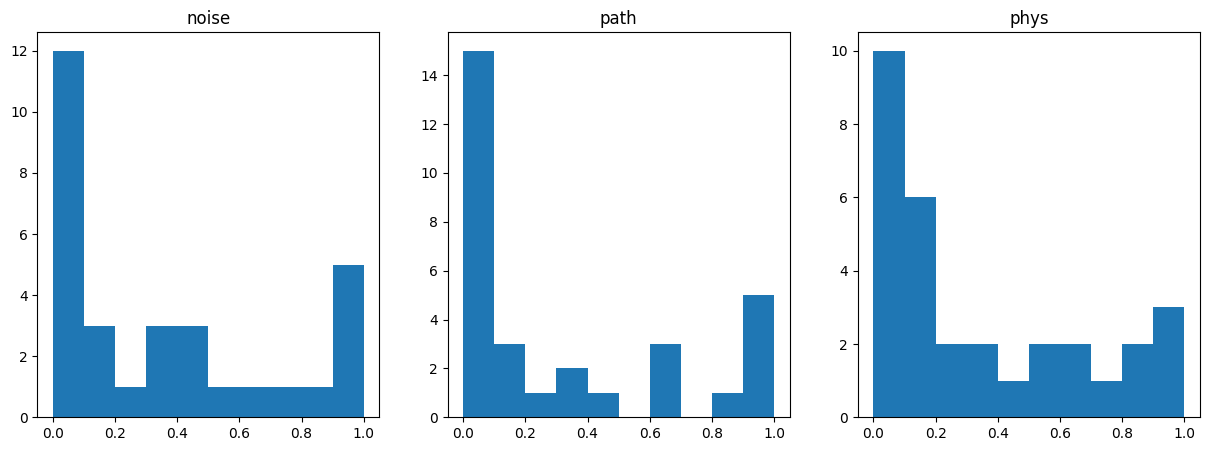

In [9]:
import matplotlib.pyplot as plt
# Check distribution as average per subj
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_total_cv
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id])/len(df_subj))
# print(counter)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

for i,cat in enumerate(counter):
    array_count = np.array(counter[cat])
    print(f'Median percentage of class {cat}: {np.median(array_count):.2}')
    _ = ax[i].hist(array_count)
    _ = ax[i].set_title(f'{cat}')


In [63]:
df_total_cv.to_csv('/scratch/mcesped/Datasets/df_total_cv.csv', sep=",", index_label='index')

### Original curation
Just limiting the amount of samples per class per subject based on the median of each class across subjects. This has the limitation that changes the distribution of the data per subject and then as a global, given way more weight to pathology!!

In [10]:
# Curate it
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_total_cv
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
subjects from inst mayo
{'noise': [0, 2892, 12, 8463, 5059, 0, 5416, 18, 0, 5876, 3339, 1343, 181, 2318, 0, 466, 4636, 2063, 1002, 12873, 0, 0, 740, 0, 3699, 4096, 1700, 5613, 1278, 58, 761], 'path': [1912, 1657, 8076, 0, 1527, 1554, 7738, 1896, 6750, 4260, 4072, 7710, 5318, 0, 883, 1923, 0, 0, 0, 0, 0, 2816, 0, 3426, 0, 0, 0, 0, 0, 3432, 2747], 'phys': [0, 7809, 0, 0, 5452, 962, 2689, 20860, 0, 1545, 2890, 38217, 14136, 330, 8653, 399, 2057, 790, 6583, 0, 25951, 0, 0, 498, 177, 6098, 3126, 0, 1424, 0, 644]}

 noise 
Number of subj: 24 
Median events per subj 2190.5 
Total events proportion 25.23208450983137 
Total events: 73902


 path 
Number of subj: 18 
Median events per subj 3121.0 
Total events proportion 23.11353447893229 
Total events: 67697


 phys 
Number of subj: 22 
Median events per subj 2789.5 
Total events proportion 51.65438101123634 
Total events: 151290



In [11]:
# Apply threshold at median
max_img_subj_cat = {
    'noise': 2190, # Pay more the noise and physiology
    'path': 3121, # Less path at it is not so hard to identify. Before in 1000
    'phys': 2789
}
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa
subjects from inst mayo


In [12]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)
for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
subjects from inst mayo
{'noise': [0, 2190, 12, 2190, 2190, 0, 2190, 18, 0, 2190, 2190, 1343, 181, 2190, 0, 466, 2190, 2063, 1002, 2190, 0, 0, 740, 0, 2190, 2190, 1700, 2190, 1278, 58, 761], 'path': [1912, 1657, 3121, 0, 1527, 1554, 3121, 1896, 3121, 3121, 3121, 3121, 3121, 0, 883, 1923, 0, 0, 0, 0, 0, 2816, 0, 3121, 0, 0, 0, 0, 0, 3121, 2747], 'phys': [0, 2789, 0, 0, 2789, 962, 2689, 2789, 0, 1545, 2789, 2789, 2789, 330, 2789, 399, 2057, 790, 2789, 0, 2789, 0, 0, 498, 177, 2789, 2789, 0, 1424, 0, 644]}

 noise 
Number of subj: 24 
Median events per subj 2126.5 
Total events proportion 29.164906580016247 
Total events: 35902


 path 
Number of subj: 18 
Median events per subj 2968.5 
Total events proportion 36.55889520714866 
Total events: 45004


 phys 
Number of subj: 22 
Median events per subj 2739.0 
Total events proportion 34.27619821283509 
Total events: 42194



In [13]:
# Check distribution per class:
for cat in np.unique(df_curated.category_name):
    print(cat, f'{len(df_curated.loc[df_curated.category_name == cat])/len(df_curated):.2f}')

noise 0.29
pathology 0.37
physiology 0.34


subjects from inst fnusa
subjects from inst mayo
Median percentage of class noise: 0.27
Median percentage of class path: 0.25
Median percentage of class phys: 0.28


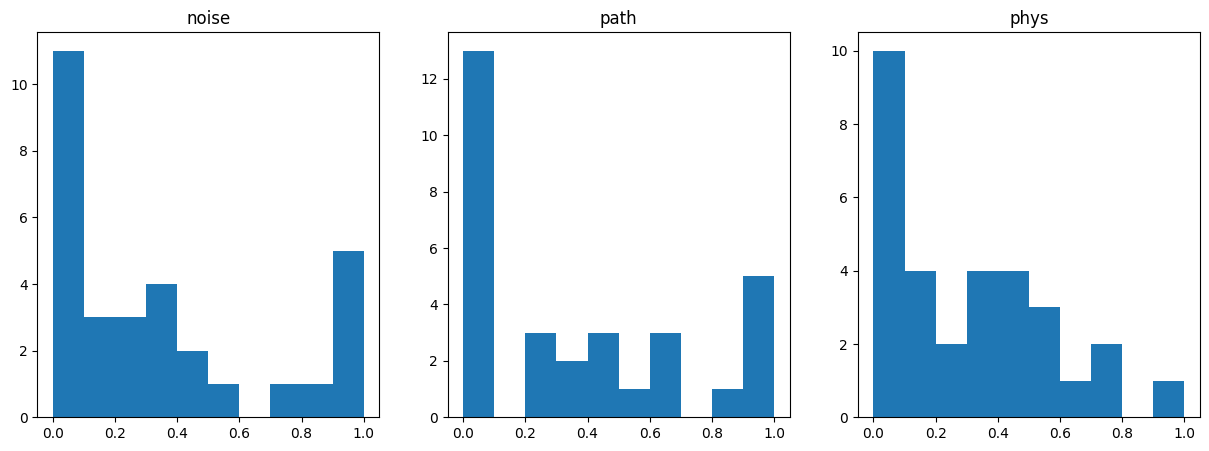

In [14]:
import matplotlib.pyplot as plt
# Check distribution as average per subj
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id])/len(df_subj))
# print(counter)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

for i,cat in enumerate(counter):
    array_count = np.array(counter[cat])
    print(f'Median percentage of class {cat}: {np.median(array_count):.2}')
    _ = ax[i].hist(array_count)
    _ = ax[i].set_title(f'{cat}')


In [15]:
df_total_cv_curated = df_curated
df_total_cv_curated.to_csv('/scratch/mcesped/Datasets/df_total_cv_curated_original.csv', sep=",", index_label='index')

In [90]:
df_total_cv_curated.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
0,hippocampus anterior,1,B'1,depth,fnusa,24,2,y007255,1,pathology
1,hippocampus anterior,1,B'1,depth,fnusa,24,2,y007470,1,pathology
2,hippocampus anterior,1,B'1,depth,fnusa,24,2,y007432,1,pathology
3,hippocampus anterior,1,B'1,depth,fnusa,24,2,y008829,1,pathology
4,hippocampus anterior,1,B'1,depth,fnusa,24,2,y008739,1,pathology


In [88]:
df_total_cv_curated.category_id.values

array([1, 1, 1, ..., 2, 2, 2])

### New curation:
Limiting samples per subject with the median samples per subject (globally) and preserving the original distribution

In [34]:
# Curate it
# Eval
counter = []
df_evaluated = df_total_cv
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        counter.append(len(df_subj))

print(counter)
median_samples_subj = int(np.median(counter))
print(f'Median samples {median_samples_subj}')

subjects from inst fnusa
subjects from inst mayo
[1912, 12358, 8088, 8463, 12038, 2516, 15843, 22774, 6750, 11681, 10301, 47270, 19635, 2648, 9536, 2788, 6693, 2853, 7585, 12873, 25951, 2816, 740, 3924, 3876, 10194, 4826, 5613, 2702, 3490, 4152]
Median samples 6750


In [35]:
# Apply threshold at median
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        if median_samples_subj < len(df_subj):
            df_tmp = []
            for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
                df_cat = df_subj.loc[df_subj.category_id==cat_id]
                # Get proportion
                cat_prop = len(df_cat)/len(df_subj)
                if len(df_tmp)<1:
                    df_tmp = df_cat.sample(int(median_samples_subj*cat_prop))
                else:
                    df_tmp = pd.concat([df_tmp, df_cat.sample(int(median_samples_subj*cat_prop))])
        else:
            df_tmp = df_subj
        if len(df_curated)<1:
            df_curated = df_tmp
        else:
            df_curated = pd.concat([df_curated, df_tmp])
            
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa
subjects from inst mayo


In [36]:
df_total_cv_curated = df_curated

In [37]:
counter = []
df_evaluated = df_total_cv_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        counter.append(len(df_subj))

print(counter)
median_samples_subj = int(np.median(counter))
print(f'Median samples {median_samples_subj}')

subjects from inst fnusa
subjects from inst mayo
[1912, 6749, 6749, 6750, 6749, 2516, 6748, 6748, 6750, 6748, 6748, 6748, 6749, 2648, 6749, 2788, 6693, 2853, 6749, 6750, 6750, 2816, 740, 3924, 3876, 6749, 4826, 5613, 2702, 3490, 4152]
Median samples 6748


In [38]:
# Check distribution per class:
for cat in np.unique(df_total_cv_curated.category_name):
    print(cat, f'{len(df_total_cv_curated.loc[df_total_cv_curated.category_name == cat])/len(df_total_cv_curated):.2f}')
print(f'Total length compared to original: {len(df_total_cv_curated)*100/len(df_total_cv):.2f}')

noise 0.33
pathology 0.29
physiology 0.38
Total length compared to original: 54.47


subjects from inst fnusa
subjects from inst mayo
Median percentage of class noise: 0.23
Median percentage of class path: 0.13
Median percentage of class phys: 0.17


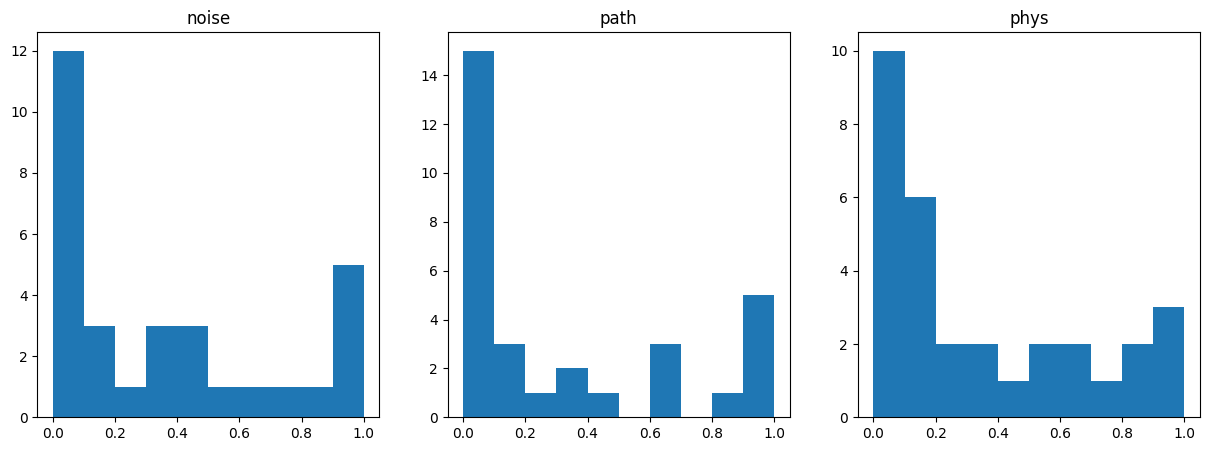

In [39]:
import matplotlib.pyplot as plt
# Check distribution as average per subj
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_total_cv_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id])/len(df_subj))
# print(counter)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

for i,cat in enumerate(counter):
    array_count = np.array(counter[cat])
    print(f'Median percentage of class {cat}: {np.median(array_count):.2}')
    _ = ax[i].hist(array_count)
    _ = ax[i].set_title(f'{cat}')


In [86]:
# Change weight of path class to 15%
target_percent = 0.2
_, (len_noise,len_path,len_phys) = np.unique(df_total_cv_curated.category_id, return_counts=True)              
percent_extract = target_percent*(len_noise + len_phys)/(len_path*(1-target_percent))
percent_extract

0.6246463738239874

In [87]:
df = df_total_cv_curated.loc[(df_total_cv_curated.category_id != 1)].reset_index(drop=True)
# Get path segments without changing the dist
df_path = df_total_cv_curated.loc[df_total_cv_curated.category_id == 1, :].reset_index(drop=True)
df_path_new = pd.DataFrame(columns= df_path.columns)
total_new_samples = percent_extract*len(df_path)
for subj in np.unique(df_path.patient_id):
    df_subj = df_path.loc[df_path.patient_id==subj]
    n_subj = int(total_new_samples*len(df_subj)/len(df_path))
    df_path_new = pd.concat([df_path_new, df_subj.sample(n=n_subj)])
df = pd.concat([df, df_path_new]).sample(frac=1).reset_index(drop=True)

In [88]:
# Check distribution per class:
for cat in np.unique(df.category_name):
    print(cat, f'{len(df.loc[df.category_name == cat])/len(df):.2f}')
print(f'Total length compared to original: {len(df)*100/len(df_total_cv):.2f}')

noise 0.37
pathology 0.20
physiology 0.43
Total length compared to original: 48.62


In [68]:
df_total_cv_curated.to_csv('/scratch/mcesped/Datasets/df_total_cv_curated_new.csv', sep=",", index_label='index')

In [5]:
df_total_cv_curated = pd.read_csv('/scratch/mcesped/Datasets/df_total_cv_curated_new.csv', sep=",", index_col="index")
df_total_cv_curated.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
0,hippocampus anterior,1,B'1,depth,fnusa,24,2,y007132,1,pathology
1,hippocampus anterior,1,B'1,depth,fnusa,24,2,y007133,1,pathology
2,hippocampus anterior,1,B'1,depth,fnusa,24,2,y007134,1,pathology
3,hippocampus anterior,1,B'1,depth,fnusa,24,2,y007135,1,pathology
4,hippocampus anterior,1,B'1,depth,fnusa,24,2,y007136,1,pathology


In [14]:
# Check samples per class
subjs_id = np.unique(df_total_cv_curated.patient_id)
# Curate it
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_total_cv_curated
for subj in np.unique(df_total_cv_curated.patient_id):
    df_subj = df_total_cv_curated.loc[df_total_cv_curated.patient_id==subj]
    for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
        counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))

no_samples_subjs = dict()
for cat in counter:
    bool_zero_samples = np.array(counter[cat])==0
    print(f'Subjects with no samples for category {cat}:')
    print(subjs_id[bool_zero_samples])
    print('\n')
    no_samples_subjs[cat] = subjs_id[bool_zero_samples]

no_samples_subjs

Subjects with no samples for category noise:
[ 1  7  8 14 24 29 32]


Subjects with no samples for category path:
[ 0  3  4  5  6  7  9 16 17 18 19 20 27]


Subjects with no samples for category phys:
[ 6  8  9 19 21 24 26 27 32]




{'noise': array([ 1,  7,  8, 14, 24, 29, 32]),
 'path': array([ 0,  3,  4,  5,  6,  7,  9, 16, 17, 18, 19, 20, 27]),
 'phys': array([ 6,  8,  9, 19, 21, 24, 26, 27, 32])}

### KFold test

In [11]:
import sklearn
from sklearn.utils.validation import check_array, check_random_state, _deprecate_positional_args
from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits

class GroupKFold(_BaseKFold):
    """K-fold iterator variant with non-overlapping groups.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    The folds are approximately balanced in the sense that the number of
    distinct groups is approximately the same in each fold.
    Read more in the :ref:`User Guide <group_k_fold>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
        .. versionchanged:: 0.22
            ``n_splits`` default value changed from 3 to 5.
    shuffle : bool, default=False
        Whether to shuffle the data before splitting into batches.
        Note that the samples within each split will not be shuffled.
    random_state : int, RandomState instance or None, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold. Otherwise, this
        parameter has no effect.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.     

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupKFold
    >>> X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
    >>> y = np.array([0, 0, 2, 2])
    >>> groups = np.array([0, 1, 2, 3])
    >>> group_kfold = GroupKFold(n_splits=2, shuffle=True, random_state=12345)
    >>> group_kfold.get_n_splits(X, y, groups)
    2
    >>> print(group_kfold)
    GroupKFold(n_splits=2, random_state=12345, shuffle=True)
    >>> for train_index, test_index in group_kfold.split(X, y, groups):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    ...    print(X_train, X_test, y_train, y_test)
    ...
    TRAIN: [0 1] TEST: [2 3]
    [[1 2]
     [3 4]] [[5 6]
     [7 8]] [0 0] [2 2]
    TRAIN: [2 3] TEST: [0 1]
    [[5 6]
     [7 8]] [[1 2]
     [3 4]] [2 2] [0 0]

    See Also
    --------
    LeaveOneGroupOut : For splitting the data according to explicit
        domain-specific stratification of the dataset.
    """
    def __init__(self, n_splits=5, *, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    def _iter_test_indices(self, X, y, groups):
        if groups is None:
            raise ValueError("The 'groups' parameter should not be None.")
        groups = check_array(groups, ensure_2d=False, dtype=None)
        
        unique_groups, groups = np.unique(groups, return_inverse=True)
        n_groups = len(unique_groups)

        if self.n_splits > n_groups:
            raise ValueError("Cannot have number of splits n_splits=%d greater"
                             " than the number of groups: %d."
                             % (self.n_splits, n_groups))

        # Weight groups by their number of occurrences
        n_samples_per_group = np.bincount(groups)

        # Distribute the most frequent groups first
        indices = np.argsort(n_samples_per_group)[::-1]
        
        if self.shuffle:
            rng = check_random_state(self.random_state)
            for n_sample in np.unique(n_samples_per_group):
                same_n_indices_index = np.where(n_samples_per_group == n_sample)[0]
                target_chunk = indices[same_n_indices_index]
                rng.shuffle(target_chunk)
                indices[same_n_indices_index] = target_chunk

        n_samples_per_group = n_samples_per_group[indices]

        # Total weight of each fold
        n_samples_per_fold = np.zeros(self.n_splits)

        # Mapping from group index to fold index
        group_to_fold = np.zeros(len(unique_groups))

        # Distribute samples by adding the largest weight to the lightest fold
        for group_index, weight in enumerate(n_samples_per_group):
            lightest_fold = np.argmin(n_samples_per_fold)
            n_samples_per_fold[lightest_fold] += weight
            group_to_fold[indices[group_index]] = lightest_fold

        indices = group_to_fold[groups]

        for f in range(self.n_splits):
            yield np.where(indices == f)[0]

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,), default=None
            The target variable for supervised learning problems.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        return super().split(X, y, groups)
    

class RepeatedGroupKFold(_RepeatedSplits):
    """Repeated Group K-Fold cross validator.
    Repeats Group K-Fold n times with different randomization in each repetition.
    Read more in the :ref:`User Guide <repeated_group_k_fold>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    n_repeats : int, default=10
        Number of times cross-validator needs to be repeated.
    random_state : int, RandomState instance or None, default=None
        Controls the randomness of each repeated cross-validation instance.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import RepeatedGroupKFold
    >>> X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
    >>> y = np.array([0, 0, 2, 2])
    >>> groups = np.array([0, 1, 2, 3])
    >>> rkf = RepeatedGroupKFold(n_splits=2, n_repeats=2, random_state=2652124)
    >>> for train_index, test_index in rkf.split(X, y, groups):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    ... 
    TRAIN: [1 2] TEST: [0 3]
    TRAIN: [0 3] TEST: [1 2]
    TRAIN: [0 1] TEST: [2 3]
    TRAIN: [2 3] TEST: [0 1]

    Notes
    -----
    Randomized CV splitters may return different results for each call of
    split. You can make the results identical by setting `random_state`
    to an integer.

    See Also
    --------
    RepeatedStratifiedKFold : Repeats Stratified K-Fold n times.
    """
    @_deprecate_positional_args
    def __init__(self, *, n_splits=5, n_repeats=10, random_state=None):
        super().__init__(
            GroupKFold, n_repeats=n_repeats,
            random_state=random_state, n_splits=n_splits)
        
    def split(self, X, y=None, groups=None):
        """Generates indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            The target variable for supervised learning problems.
        groups : array-like of shape (n_samples,), default=None
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        n_repeats = self.n_repeats
        rng = check_random_state(self.random_state)

        for idx in range(n_repeats):
            cv = self.cv(random_state=rng, shuffle=True,
                            **self.cvargs)
            for train_index, test_index in cv.split(X, y, groups):
                yield train_index, test_index

In [45]:
# Find random state with val set with all categories

import numpy as np
# from sklearn.model_selection import GroupKFold

# Sample data
X = df_total_cv_curated.segment_id.values  # Your data
y = df_total_cv_curated.category_id.values  # Your labels
# Define groups where each group represents a different subject
groups = df_total_cv_curated.patient_id.values  # Random grouping for illustration

# Define the number of splits
n_splits = 10

# Create GroupKFold with a custom generator to ensure groups stay together
# gkf = GroupKFold(n_splits=n_splits)
for rand in range(0,100):
    gkf = RepeatedGroupKFold(n_splits=n_splits, n_repeats=2, random_state=rand)
    
    # Initialize lists to store train and validation indices
    train_indices_list = []
    val_indices_list = []
    
    # Generate train and validation indices for each split
    
    for train_indices, val_indices in gkf.split(X, y, groups=groups):
        train_indices_list.append(train_indices)
        val_indices_list.append(val_indices)
    
    # Generate dataframes train and val
    no_samples = []
    for split_idx, (train_indices, val_indices) in enumerate(zip(train_indices_list, val_indices_list)):
        # print(f"Split {split_idx+1}:")
        df_train = df_total_cv_curated.iloc[train_indices,:].reset_index(drop=True)
        # print("Train indices:", train_indices)
        # print("Subjs train:", np.unique(df_train.patient_id.values))
        # print("Validation indices:", val_indices)
        df_val = df_total_cv_curated.iloc[val_indices,:].reset_index(drop=True)
        # print("Subjs val:", np.unique(df_val.patient_id.values))
    
        # Check if all of the the are no samples of 1 class in val set
        for cat in no_samples_subjs:
            cond = all(subj in no_samples_subjs[cat] for subj in np.unique(df_val.patient_id.values))
            if cond:
                no_samples.append(f'Fold {split_idx} has no samples for cat {cat}')
                # print(f'Fold {split_idx} has no samples for cat {cat}')
        # print('\n')
    if len(no_samples) == 0:
        print(rand)

46
54
58
63


In [48]:
import numpy as np
# from sklearn.model_selection import GroupKFold

# Sample data
X = df_total_cv_curated.segment_id.values  # Your data
y = df_total_cv_curated.category_id.values  # Your labels
# Define groups where each group represents a different subject
groups = df_total_cv_curated.patient_id.values  # Random grouping for illustration

# Define the number of splits
n_splits = 10

# Create GroupKFold with a custom generator to ensure groups stay together
# gkf = GroupKFold(n_splits=n_splits)
gkf = RepeatedGroupKFold(n_splits=n_splits, n_repeats=2, random_state=46)

# Initialize lists to store train and validation indices
train_indices_list = []
val_indices_list = []

# Generate train and validation indices for each split

for train_indices, val_indices in gkf.split(X, y, groups=groups):
    train_indices_list.append(train_indices)
    val_indices_list.append(val_indices)

# Generate dataframes train and val
no_samples = []
for split_idx, (train_indices, val_indices) in enumerate(zip(train_indices_list, val_indices_list)):
    print(f"Split {split_idx+1}:")
    df_train = df_total_cv_curated.iloc[train_indices,:].reset_index(drop=True)
    # print("Train indices:", train_indices)
    print("Subjs train:", np.unique(df_train.patient_id.values))
    # print("Validation indices:", val_indices)
    df_val = df_total_cv_curated.iloc[val_indices,:].reset_index(drop=True)
    print("Subjs val:", np.unique(df_val.patient_id.values))

    # Check if all of the the are no samples of 1 class in val set
    for cat in no_samples_subjs:
        cond = all(subj in no_samples_subjs[cat] for subj in np.unique(df_val.patient_id.values))
        if cond:
            # no_samples.append(f'Fold {split_idx} has no samples for cat {cat}')
            print(f'Fold {split_idx} has no samples for cat {cat}')
    print('\n')

Split 1:
Subjs train: [ 0  1  3  4  5  6  7  8  9 14 16 17 18 20 21 23 24 25 26 28 29 30 31 32
 33 34 35 36]
Subjs val: [ 2 19 27]


Split 2:
Subjs train: [ 0  2  3  5  6  7  8 16 17 18 19 20 21 23 24 25 26 27 28 29 30 31 32 33
 34 35 36]
Subjs val: [ 1  4  9 14]


Split 3:
Subjs train: [ 0  1  2  3  4  5  6  8  9 14 16 17 19 20 21 23 24 25 26 27 28 30 31 32
 33 34 35 36]
Subjs val: [ 7 18 29]


Split 4:
Subjs train: [ 0  1  2  3  4  5  6  7  8  9 14 16 17 18 19 20 24 25 26 27 28 29 30 31
 33 34 35 36]
Subjs val: [21 23 32]


Split 5:
Subjs train: [ 0  1  2  3  4  5  7  8  9 14 16 17 18 19 20 21 23 24 25 26 27 28 29 31
 32 33 34 35]
Subjs val: [ 6 30 36]


Split 6:
Subjs train: [ 1  2  3  4  5  6  7  8  9 14 16 18 19 20 21 23 24 25 26 27 28 29 30 31
 32 33 35 36]
Subjs val: [ 0 17 34]


Split 7:
Subjs train: [ 0  1  2  3  4  5  6  7  8  9 14 16 17 18 19 20 21 23 25 27 28 29 30 31
 32 34 35 36]
Subjs val: [24 26 33]


Split 8:
Subjs train: [ 0  1  2  3  4  5  6  7  8  9 14 16 17 18 19 2

In [94]:
df_train.tail()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
98539,NaN,2,LAD_3,depth,mayo,23,1,x151806,0,physiology
98540,NaN,2,LAD_1,depth,mayo,23,1,x151102,0,physiology
98541,NaN,2,LAD_1,depth,mayo,23,1,x151117,0,physiology
98542,NaN,2,LAD_1,depth,mayo,23,1,x151150,0,physiology
98543,NaN,2,LAD_3,depth,mayo,23,1,x152004,0,physiology


# Noise detection dataset
I'll balance the classes manually to have a similar amount of training examples per subject. The biggest will be training 

In [3]:
df_fnusa_no_pw = df_fnusa.loc[df_fnusa.category_id != 0]
df_fnusa_no_pw.loc[:,'category_id'] = df_fnusa_no_pw.category_id - 1

df_mayo_no_pw = df_mayo.loc[df_mayo.category_id != 0]
df_mayo_no_pw.loc[:,'category_id'] = df_mayo_no_pw.category_id - 1

df_fnusa_no_pw.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
7132,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007132,1,pathology
7133,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007133,1,pathology
7134,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007134,1,pathology
7135,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007135,1,pathology
7136,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007136,1,pathology


## Balance Fnusa

Not touching test set as I'll probably do bootstrapping for that

In [4]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_fnusa_no_pw
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
{'noise': [0, 2892, 12, 8463, 5059, 0, 5416, 18, 0, 5876, 3339, 1343, 181], 'path': [1912, 1657, 8076, 0, 1527, 1554, 7738, 1896, 6750, 4260, 4072, 7710, 5318], 'phys': [0, 7809, 0, 0, 5452, 962, 2689, 20860, 0, 1545, 2890, 38217, 14136]}

 noise 
Number of subj: 10 
Median events per subj 3115.5 
Total events proportion 18.147960518624497 
Total events: 32599


 path 
Number of subj: 12 
Median events per subj 4166.0 
Total events proportion 29.21020547907075 
Total events: 52470


 phys 
Number of subj: 9 
Median events per subj 5452.0 
Total events proportion 52.64183400230475 
Total events: 94560



In [5]:
# Manually picked choice
# For training: 1500, 2000, 1200. 
# For val 4000, 2000, 2000
max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 800, # Less path at it is not so hard to identify
    'phys': 1500
}
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa


In [6]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)
for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
{'noise': [0, 2892, 12, 3000, 3000, 0, 3000, 18, 0, 3000, 3000, 1343, 181], 'path': [800, 800, 800, 0, 800, 800, 800, 800, 800, 800, 800, 800, 800], 'phys': [0, 1500, 0, 0, 1500, 962, 1500, 1500, 0, 1500, 1500, 1500, 1500]}

 noise 
Number of subj: 10 
Median events per subj 2946.0 
Total events proportion 46.29118263187964 
Total events: 19446


 path 
Number of subj: 12 
Median events per subj 800.0 
Total events proportion 22.852789944772425 
Total events: 9600


 phys 
Number of subj: 9 
Median events per subj 1500.0 
Total events proportion 30.856027423347935 
Total events: 12962



In [7]:
df_curated_fnusa = df_curated

In [18]:
len(df_curated_fnusa)

42008

## Balance Mayo

In [8]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_mayo_no_pw
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst mayo
{'noise': [2318, 0, 466, 4636, 2063, 1002, 12873, 0, 0, 740, 0, 3699, 4096, 1700, 5613, 1278, 58, 761], 'path': [0, 883, 1923, 0, 0, 0, 0, 0, 2816, 0, 3426, 0, 0, 0, 0, 0, 3432, 2747], 'phys': [330, 8653, 399, 2057, 790, 6583, 0, 25951, 0, 0, 498, 177, 6098, 3126, 0, 1424, 0, 644]}

 noise 
Number of subj: 14 
Median events per subj 1881.5 
Total events proportion 36.46742009535582 
Total events: 41303


 path 
Number of subj: 6 
Median events per subj 2781.5 
Total events proportion 13.444287480134204 
Total events: 15227


 phys 
Number of subj: 13 
Median events per subj 1424.0 
Total events proportion 50.08829242450998 
Total events: 56730



In [9]:
# Manually picked choice
# For training: 1500, 2000, 1200. 
# For val 4000, 2000, 2000
max_img_subj_cat = {
    'noise': 2000, # Pay more the noise
    'path': 1500, # Less path at it is not so hard to identify
    'phys': 1300
}
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst mayo


In [10]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)
for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst mayo
{'noise': [2000, 0, 466, 2000, 2000, 1002, 2000, 0, 0, 740, 0, 2000, 2000, 1700, 2000, 1278, 58, 761], 'path': [0, 883, 1500, 0, 0, 0, 0, 0, 1500, 0, 1500, 0, 0, 0, 0, 0, 1500, 1500], 'phys': [330, 1300, 399, 1300, 790, 1300, 0, 1300, 0, 0, 498, 177, 1300, 1300, 0, 1300, 0, 644]}

 noise 
Number of subj: 14 
Median events per subj 1850.0 
Total events proportion 49.6081932252145 
Total events: 20005


 path 
Number of subj: 6 
Median events per subj 1500.0 
Total events proportion 20.788077171055896 
Total events: 8383


 phys 
Number of subj: 13 
Median events per subj 1300.0 
Total events proportion 29.603729603729604 
Total events: 11938



In [11]:
df_curated_mayo = df_curated

In [12]:
len(df_curated_mayo), len(df_curated_fnusa)

(40326, 42008)

In [13]:
df_train = df_curated_fnusa
df_val = df_curated_mayo

In [14]:
# Write csv files. Using fnusa as train
df_train.to_csv('/scratch/mcesped/Datasets/Noise_detection/df_train_curated.csv', sep=",", index_label='index')
df_val.to_csv('/scratch/mcesped/Datasets/Noise_detection/df_val_curated.csv', sep=",", index_label='index')
# df_test.to_csv('/scratch/mcesped/Datasets/Noise_detection/df_test.csv', sep=",", index_label='index')

In [16]:
df_fnusa_no_pw.to_csv('/scratch/mcesped/Datasets/Noise_detection/df_train_full.csv', sep=",", index_label='index')
df_mayo_no_pw.to_csv('/scratch/mcesped/Datasets/Noise_detection/df_val_full.csv', sep=",", index_label='index')

# Path detection dataset
I'll balance the classes manually to have a similar amount of training examples per subject. The biggest will be training 

In [3]:
df_fnusa_no_pw = df_fnusa.loc[df_fnusa.category_id != 0]
df_fnusa_no_pw.loc[:,'category_id'] = df_fnusa_no_pw.category_id - 1

df_mayo_no_pw = df_mayo.loc[df_mayo.category_id != 0]
df_mayo_no_pw.loc[:,'category_id'] = df_mayo_no_pw.category_id - 1

df_fnusa_no_pw.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
7132,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007132,1,pathology
7133,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007133,1,pathology
7134,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007134,1,pathology
7135,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007135,1,pathology
7136,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007136,1,pathology


In [36]:
df_fnusa_no_pw.loc[df_fnusa_no_pw.category_id == 2]

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
9044,amygdala,2,A'1,depth,fnusa,2,3,y009044,0,physiology
9045,amygdala,2,A'1,depth,fnusa,2,3,y009045,0,physiology
9046,amygdala,2,A'1,depth,fnusa,2,3,y009046,0,physiology
9047,amygdala,2,A'1,depth,fnusa,2,3,y009047,0,physiology
9048,amygdala,2,A'1,depth,fnusa,2,3,y009048,0,physiology
...,...,...,...,...,...,...,...,...,...,...
193113,gyrus frontalis medius,2,G9,depth,fnusa,13,1,y193113,0,physiology
193114,gyrus frontalis medius,2,G9,depth,fnusa,13,1,y193114,0,physiology
193115,gyrus frontalis medius,2,G9,depth,fnusa,13,1,y193115,0,physiology


In [46]:
df_train = df_fnusa_no_pw.replace({'category_id': {2:0}})
df_train.loc[df_fnusa_no_pw.category_id == 0]

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
9105,amygdala,0,A'1,depth,fnusa,2,2,y009105,0,noise
9106,amygdala,0,A'1,depth,fnusa,2,2,y009106,0,noise
9107,amygdala,0,A'1,depth,fnusa,2,2,y009107,0,noise
9108,amygdala,0,A'1,depth,fnusa,2,2,y009108,0,noise
9109,amygdala,0,A'1,depth,fnusa,2,2,y009109,0,noise
...,...,...,...,...,...,...,...,...,...,...
180390,hippocampus posterior,0,C3,depth,fnusa,13,3,y180390,0,noise
180393,wm,0,C4,depth,fnusa,13,3,y180393,0,noise
180413,wm,0,C4,depth,fnusa,13,3,y180413,0,noise


## Balance Fnusa

Not touching test set as I'll probably do bootstrapping for that

In [12]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_fnusa_no_pw
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
{'noise': [0, 2892, 12, 8463, 5059, 0, 5416, 18, 0, 5876, 3339, 1343, 181], 'path': [1912, 1657, 8076, 0, 1527, 1554, 7738, 1896, 6750, 4260, 4072, 7710, 5318], 'phys': [0, 7809, 0, 0, 5452, 962, 2689, 20860, 0, 1545, 2890, 38217, 14136]}

 noise 
Number of subj: 10 
Median events per subj 3115.5 
Total events proportion 18.147960518624497 
Total events: 32599


 path 
Number of subj: 12 
Median events per subj 4166.0 
Total events proportion 29.21020547907075 
Total events: 52470


 phys 
Number of subj: 9 
Median events per subj 5452.0 
Total events proportion 52.64183400230475 
Total events: 94560



In [13]:
# Manually picked choice
# For training: 1500, 2000, 1200. 
# For val 4000, 2000, 2000
max_img_subj_cat = {
    'noise': 3000, # Pay more the noise
    'path': 4000, # Less path at it is not so hard to identify
    'phys': 3000
}
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa


In [14]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)
for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
{'noise': [0, 2892, 12, 3000, 3000, 0, 3000, 18, 0, 3000, 3000, 1343, 181], 'path': [1912, 1657, 4000, 0, 1527, 1554, 4000, 1896, 4000, 4000, 4000, 4000, 4000], 'phys': [0, 3000, 0, 0, 3000, 962, 2689, 3000, 0, 1545, 2890, 3000, 3000]}

 noise 
Number of subj: 10 
Median events per subj 2946.0 
Total events proportion 24.590910240522017 
Total events: 19446


 path 
Number of subj: 12 
Median events per subj 4000.0 
Total events proportion 46.21512936594249 
Total events: 36546


 phys 
Number of subj: 9 
Median events per subj 3000.0 
Total events proportion 29.193960393535498 
Total events: 23086



In [15]:
df_curated_fnusa = df_curated

In [16]:
len(df_curated_fnusa)

79078

## Balance Mayo

In [28]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_mayo_no_pw
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst mayo
{'noise': [2318, 0, 466, 4636, 2063, 1002, 12873, 0, 0, 740, 0, 3699, 4096, 1700, 5613, 1278, 58, 761], 'path': [0, 883, 1923, 0, 0, 0, 0, 0, 2816, 0, 3426, 0, 0, 0, 0, 0, 3432, 2747], 'phys': [330, 8653, 399, 2057, 790, 6583, 0, 25951, 0, 0, 498, 177, 6098, 3126, 0, 1424, 0, 644]}

 noise 
Number of subj: 14 
Median events per subj 1881.5 
Total events proportion 36.46742009535582 
Total events: 41303


 path 
Number of subj: 6 
Median events per subj 2781.5 
Total events proportion 13.444287480134204 
Total events: 15227


 phys 
Number of subj: 13 
Median events per subj 1424.0 
Total events proportion 50.08829242450998 
Total events: 56730



In [29]:
# Manually picked choice
# For training: 1500, 2000, 1200. 
# For val 4000, 2000, 2000
max_img_subj_cat = {
    'noise': 700, # Pay more the noise
    'path': 2700, # Less path at it is not so hard to identify
    'phys': 800
}
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst mayo


In [30]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)
for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst mayo
{'noise': [700, 0, 466, 700, 700, 700, 700, 0, 0, 700, 0, 700, 700, 700, 700, 700, 58, 700], 'path': [0, 883, 1923, 0, 0, 0, 0, 0, 2700, 0, 2700, 0, 0, 0, 0, 0, 2700, 2700], 'phys': [330, 800, 399, 800, 790, 800, 0, 800, 0, 0, 498, 177, 800, 800, 0, 800, 0, 644]}

 noise 
Number of subj: 14 
Median events per subj 700.0 
Total events proportion 28.81684319297339 
Total events: 8924


 path 
Number of subj: 6 
Median events per subj 2700.0 
Total events proportion 43.9356755360372 
Total events: 13606


 phys 
Number of subj: 13 
Median events per subj 800.0 
Total events proportion 27.247481270989407 
Total events: 8438



In [31]:
df_curated_mayo = df_curated

In [32]:
len(df_curated_mayo), len(df_curated_fnusa)

(30968, 79078)

In [33]:
df_train = df_curated_fnusa
df_val = df_curated_mayo

In [34]:
# Write csv files. Using fnusa as train
df_train.to_csv('/scratch/mcesped/Datasets/Path_detection/df_train_curated.csv', sep=",", index_label='index')
df_val.to_csv('/scratch/mcesped/Datasets/Path_detection/df_val_curated.csv', sep=",", index_label='index')
# df_test.to_csv('/scratch/mcesped/Datasets/Noise_detection/df_test.csv', sep=",", index_label='index')

In [35]:
df_fnusa_no_pw.to_csv('/scratch/mcesped/Datasets/Path_detection/df_train_full.csv', sep=",", index_label='index')
df_mayo_no_pw.to_csv('/scratch/mcesped/Datasets/Path_detection/df_val_full.csv', sep=",", index_label='index')

# Multiclass (3 classes)

In [33]:
df_fnusa_no_pw = df_fnusa.loc[df_fnusa.category_id != 0]
df_fnusa_no_pw.loc[:,'category_id'] = df_fnusa_no_pw.category_id - 1

df_mayo_no_pw = df_mayo.loc[df_mayo.category_id != 0]
df_mayo_no_pw.loc[:,'category_id'] = df_mayo_no_pw.category_id - 1

df_fnusa_no_pw.head()

,anatomy,category_id,channel,electrode_type,institution,patient_id,reviewer_id,segment_id,soz,category_name
index,,,,,,,,,,
7132,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007132,1,pathology
7133,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007133,1,pathology
7134,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007134,1,pathology
7135,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007135,1,pathology
7136,hippocampus anterior,1,B'1,depth,fnusa,1,2,y007136,1,pathology


## Balance Fnusa

Not touching test set as I'll probably do bootstrapping for that

In [38]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_fnusa_no_pw
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
{'noise': [0, 2892, 12, 8463, 5059, 0, 5416, 18, 0, 5876, 3339, 1343, 181], 'path': [1912, 1657, 8076, 0, 1527, 1554, 7738, 1896, 6750, 4260, 4072, 7710, 5318], 'phys': [0, 7809, 0, 0, 5452, 962, 2689, 20860, 0, 1545, 2890, 38217, 14136]}

 noise 
Number of subj: 10 
Median events per subj 3115.5 
Total events proportion 18.147960518624497 
Total events: 32599


 path 
Number of subj: 12 
Median events per subj 4166.0 
Total events proportion 29.21020547907075 
Total events: 52470


 phys 
Number of subj: 9 
Median events per subj 5452.0 
Total events proportion 52.64183400230475 
Total events: 94560



In [39]:
max_img_subj_cat = {
    'noise': 3100, # Pay more the noise and physiology
    'path': 700, # Less path at it is not so hard to identify. Before in 1000
    'phys': 5000
}
df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst fnusa


In [40]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)
for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst fnusa
{'noise': [0, 2892, 12, 3100, 3100, 0, 3100, 18, 0, 3100, 3100, 1343, 181], 'path': [700, 700, 700, 0, 700, 700, 700, 700, 700, 700, 700, 700, 700], 'phys': [0, 5000, 0, 0, 5000, 962, 2689, 5000, 0, 1545, 2890, 5000, 5000]}

 noise 
Number of subj: 10 
Median events per subj 2996.0 
Total events proportion 32.46842036723532 
Total events: 19946


 path 
Number of subj: 12 
Median events per subj 700.0 
Total events proportion 13.673655423883318 
Total events: 8400


 phys 
Number of subj: 9 
Median events per subj 5000.0 
Total events proportion 53.857924208881364 
Total events: 33086



In [9]:
df_curated_fnusa = df_curated

In [10]:
len(df_curated_fnusa)

56432

## Balance Mayo

In [41]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_mayo_no_pw
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)

for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst mayo
{'noise': [2318, 0, 466, 4636, 2063, 1002, 12873, 0, 0, 740, 0, 3699, 4096, 1700, 5613, 1278, 58, 761], 'path': [0, 883, 1923, 0, 0, 0, 0, 0, 2816, 0, 3426, 0, 0, 0, 0, 0, 3432, 2747], 'phys': [330, 8653, 399, 2057, 790, 6583, 0, 25951, 0, 0, 498, 177, 6098, 3126, 0, 1424, 0, 644]}

 noise 
Number of subj: 14 
Median events per subj 1881.5 
Total events proportion 36.46742009535582 
Total events: 41303


 path 
Number of subj: 6 
Median events per subj 2781.5 
Total events proportion 13.444287480134204 
Total events: 15227


 phys 
Number of subj: 13 
Median events per subj 1424.0 
Total events proportion 50.08829242450998 
Total events: 56730



In [42]:
# Manually picked choice
# Val for multiclass
max_img_subj_cat = {
    'noise': 1500, # Pay more the noise
    'path': 2800, # Less path at it is not so hard to identify
    'phys': 2000
}
# Val for OVR - balanced
max_img_subj_cat = {
    'noise': 1300, # Pay more the noise
    'path': 2800, # Less path at it is not so hard to identify
    'phys': 1700
}

# Val for OVR - imbalanced. Just limiting to the average 
max_img_subj_cat = {
    'noise': 1882, # Pay more the noise
    'path': 2782, # Less path at it is not so hard to identify
    'phys': 1424
}

df_curated = []
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            df_cat = df_subj.loc[df_subj.category_id==cat_id]
            if len(df_curated)<1:
                df_curated = df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))
            else:
                df_curated = pd.concat([df_curated, df_cat.sample(min(len(df_cat),max_img_subj_cat[cat_name]))])
df_curated = df_curated.reset_index(drop=True)

subjects from inst mayo


In [43]:
# Eval
counter = {
    'noise':[],
    'path':[],
    'phys':[]
}
df_evaluated = df_curated
for inst in np.unique(df_evaluated.institution):
    df_inst = df_evaluated.loc[df_evaluated.institution==inst]
    print(f'subjects from inst {inst}')
    for subj in np.unique(df_inst.patient_id):
        df_subj = df_inst.loc[df_inst.patient_id==subj]
        for cat_id, cat_name in [(0, 'noise'), (1, 'path'), (2,'phys')]:
            counter[cat_name].append(len(df_subj.loc[df_subj.category_id==cat_id]))
print(counter)
for cat in counter:
    array_count = np.array(counter[cat])
    print('\n',cat,f'\nNumber of subj: {len(array_count[array_count!=0])}', f'\nMedian events per subj {np.median(array_count[array_count!=0])}',f'\nTotal events proportion {np.sum(array_count)*100/len(df_evaluated)}', f'\nTotal events: {np.sum(array_count)}\n')

subjects from inst mayo
{'noise': [1882, 0, 466, 1882, 1882, 1002, 1882, 0, 0, 740, 0, 1882, 1882, 1700, 1882, 1278, 58, 761], 'path': [0, 883, 1923, 0, 0, 0, 0, 0, 2782, 0, 2782, 0, 0, 0, 0, 0, 2782, 2747], 'phys': [330, 1424, 399, 1424, 790, 1424, 0, 1424, 0, 0, 498, 177, 1424, 1424, 0, 1424, 0, 644]}

 noise 
Number of subj: 14 
Median events per subj 1791.0 
Total events proportion 41.79888414262052 
Total events: 19179


 path 
Number of subj: 6 
Median events per subj 2764.5 
Total events proportion 30.29160491674658 
Total events: 13899


 phys 
Number of subj: 13 
Median events per subj 1424.0 
Total events proportion 27.9095109406329 
Total events: 12806



In [26]:
df_curated_mayo = df_curated

In [27]:
df_curated_mayo.to_csv('/scratch/mcesped/Datasets/Multiclass/df_val_curated_OVR_imbalanced.csv', sep=",", index_label='index')

In [15]:
len(df_curated_mayo), len(df_curated_fnusa)

(46520, 56432)

In [16]:
df_train = df_curated_fnusa
df_val = df_curated_mayo

In [17]:
# Write csv files. Using fnusa as train
df_train.to_csv('/scratch/mcesped/Datasets/Multiclass/df_train_curated.csv', sep=",", index_label='index')
df_val.to_csv('/scratch/mcesped/Datasets/Multiclass/df_val_curated.csv', sep=",", index_label='index')
# df_test.to_csv('/scratch/mcesped/Datasets/Noise_detection/df_test.csv', sep=",", index_label='index')

In [47]:
df_fnusa_no_pw.to_csv('/scratch/mcesped/Datasets/Multiclass/df_train_full.csv', sep=",", index_label='index')
df_mayo_no_pw.to_csv('/scratch/mcesped/Datasets/Multiclass/df_val_full.csv', sep=",", index_label='index')